## Setup

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, add, Flatten, Dense, DepthwiseConv2D, concatenate
import cv2
import matplotlib.pyplot as plt
import os, datetime

In [ ]:
def PEPXModel(input_tensor, filters, name):
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'FP')(input_tensor)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Expansion')(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same', name=name + 'DWConv3_3')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'SP')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Extension')(x)
    return x


def keras_model_build(input_size=(224, 224, 3)):
    
    #
    #
    #
    ######### 1. branch


    input1 = Input(shape=input_size, name='input')
    x = Conv2D(input_shape=input_size, filters=64, kernel_size=(7, 7), activation='relu', padding='same',
               strides=(2, 2))(input1)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # PEPX1_Conv1x1
    p_1_y = Conv2D(256, (1, 1), padding='same', activation='relu', name='PEPX1_Conv')(x)
    # Stage1结构
    y_1_1 = PEPXModel(x, 256, 'PEPX1.1')
    y_1_2 = PEPXModel(add([y_1_1, p_1_y]), 256, 'PEPX1.2')
    y_1_3 = PEPXModel(add([y_1_1, y_1_2, p_1_y]), 256, 'PEPX1.3')
    # PEPX2_Conv1x1
    p_2_y = Conv2D(512, (1, 1), padding='same', activation='relu', name='PEPX2_Conv')(add([p_1_y, y_1_1, y_1_2, y_1_3]))
    p_2_y = MaxPool2D(pool_size=(2, 2))(p_2_y)
    # Stage2结构
    y_2_1 = PEPXModel(add([y_1_3, y_1_2, y_1_1, p_1_y]), 512, 'PEPX2.1')
    y_2_1 = MaxPool2D(pool_size=(2, 2))(y_2_1)
    y_2_2 = PEPXModel(add([y_2_1, p_2_y]), 512, 'PEPX2.2')
    y_2_3 = PEPXModel(add([y_2_1, y_2_2, p_2_y]), 512, 'PEPX2.3')
    y_2_4 = PEPXModel(add([y_2_1, y_2_2, y_2_3, p_2_y]), 512, 'PEPX2.4')
    # PEPX3_Conv1x1
    p_3_y = Conv2D(1024, (1, 1), padding='same', activation='relu', name='PEPX3_Conv')(
        add([p_2_y, y_2_1, y_2_2, y_2_3, y_2_4])
    )
    p_3_y = MaxPool2D(pool_size=(2, 2))(p_3_y)
    # Stage3结构
    y_3_1 = PEPXModel(add([y_2_1, y_2_2, y_2_3, y_2_4, p_2_y]), 1024, 'PEPX3.1')
    y_3_1 = MaxPool2D(pool_size=(2, 2))(y_3_1)
    y_3_2 = PEPXModel(y_3_1, 1024, 'PEPX3.2')
    y_3_3 = PEPXModel(add([y_3_1, y_3_2]), 1024, 'PEPX3.3')
    y_3_4 = PEPXModel(add([y_3_1, y_3_2, y_3_3]), 1024, 'PEPX3.4')
    y_3_5 = PEPXModel(add([y_3_1, y_3_2, y_3_3, y_3_4]), 1024, 'PEPX3.5')
    y_3_6 = PEPXModel(add([y_3_1, y_3_2, y_3_3, y_3_4, y_3_5]), 1024, 'PEPX3.6')
    # PEPX4_Conv1x1
    p_4_y = Conv2D(2048, (1, 1), padding='same', activation='relu', name='PEPX4_Conv1')(
        add([p_3_y, y_3_1, y_3_2, y_3_3, y_3_4, y_3_5, y_3_6])
    )
    p_4_y = MaxPool2D(pool_size=(2, 2))(p_4_y)
    # Stage4结构
    y_4_1 = PEPXModel(add([y_3_1, y_3_2, y_3_3, y_3_4, y_3_5, y_3_6, p_3_y]), 2048, 'PEPX4.1')
    y_4_1 = MaxPool2D(pool_size=(2, 2))(y_4_1)
    y_4_2 = PEPXModel(add([y_4_1, p_4_y]), 2048, 'PEPX4.2')
    y_4_3 = PEPXModel(add([y_4_1, y_4_2, p_4_y]), 2048, 'PEPX4.3')
    
    # FC
    fla = Flatten()(add([y_4_1, y_4_2, y_4_3, p_4_y]))
    x = keras.models.Model(inputs=input1, outputs=fla)

    #
    #
    #
    ######### 2. branch
    input2 = Input(shape=(4), name='input2')
    y = Dense(8, activation="relu")(input2)
    y = Dense(4, activation="relu")(y)
    fla2 = Flatten()(y)
    y = keras.models.Model(inputs=input2, outputs=fla2) 


    ######### concat
    combined = concatenate([x.output, y.output])  


    d1 = Dense(1024, activation='relu')(combined)
    d2 = Dense(256, activation='relu')(d1)
    output = Dense(3, activation='softmax')(d2)

    return keras.models.Model(inputs = [x.input, y.input], outputs = output)

In [ ]:
def confusion_matrix_info(y_true, y_pred, labels=['normal', 'pneumonia', 'COVID-19'],
                          title='confusion matrix'):
    import seaborn as sns
    import pandas as pd
    from sklearn.metrics import confusion_matrix, f1_score
    import matplotlib.pyplot as plt
    C2 = confusion_matrix(y_true, y_pred)
    C = pd.DataFrame(C2, columns=labels, index=labels)
    m, _ = C2.shape
    for i in range(m):
        precision = C2[i, i] / sum(C2[:, i])
        recall = C2[i, i] / sum(C2[i, :])
        f1 = 2 * precision * recall / (precision + recall)
        print('In class {}:\t total samples: {}\t true predict samples: {}\t'
              'acc={:.4f},\trecall={:.4f},\tf1-score={:.4f}'.format(
            labels[i], sum(C2[i, :]), C2[i, i], precision, recall, f1))
    print('-' * 100, '\n', 'average f1={:.4f}'.format(f1_score(y_true, y_pred, average='micro')))

    f, ax = plt.subplots()
    sns.heatmap(C, annot=True, ax=ax, cmap=plt.cm.binary)
    ax.set_title(title)
    ax.set_xlabel('predict')
    ax.set_ylabel('true')
    plt.savefig(title+'.jpg')


In [ ]:
def train():
    x = np.load('/content/drive/MyDrive/data/x_train.npy')
    y = np.load('/content/drive/MyDrive/data/y_train.npy')
    y = tf.keras.utils.to_categorical(y, 3)
    model = keras_model_build()
    # model.summary()
    opt=tf.keras.optimizers.Adam(lr=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    

    hist = model.fit([x, meta], y, batch_size=32, epochs=1, verbose=1, callbacks=[])
    #model.save('model.h5')
    y_pred = model.predict([x, meta])
    confusion_matrix_info(np.argmax(y, axis=1), np.argmax(y_pred, axis=1),title='confusion_matrix_train')

## Trenowanie

In [ ]:
#szybkie generowanie "metadanych" numerycznych
x = np.linspace(1, 20, 36)
meta = x.reshape(9, 4)
meta

array([[ 1.        ,  1.54285714,  2.08571429,  2.62857143],
       [ 3.17142857,  3.71428571,  4.25714286,  4.8       ],
       [ 5.34285714,  5.88571429,  6.42857143,  6.97142857],
       [ 7.51428571,  8.05714286,  8.6       ,  9.14285714],
       [ 9.68571429, 10.22857143, 10.77142857, 11.31428571],
       [11.85714286, 12.4       , 12.94285714, 13.48571429],
       [14.02857143, 14.57142857, 15.11428571, 15.65714286],
       [16.2       , 16.74285714, 17.28571429, 17.82857143],
       [18.37142857, 18.91428571, 19.45714286, 20.        ]])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1/1 [==============================] - 30s 30s/step - loss: 1.0982 - accuracy: 0.3333
In class normal:	 total samples: 3	 true predict samples: 3	acc=1.0000,	recall=1.0000,	f1-score=1.0000
In class pneumonia:	 total samples: 3	 true predict samples: 3	acc=0.5000,	recall=1.0000,	f1-score=0.6667
In class COVID-19:	 total samples: 3	 true predict samples: 0	acc=nan,	recall=0.0000,	f1-score=nan
---------------------------------------------------------------------------------------------------- 
 average f1=0.6667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


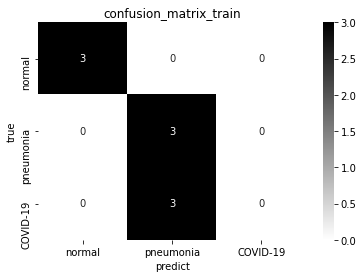

In [ ]:
train()


zbiór covid-chestxray ma odrobinę metadanych, można z nich wybrać akurat tyle, ile tu wziąłem, 4 kolumny